## Helpers and Imports

In [ ]:
import pandas as pd
import numpy as np
import torch
from typing import Tuple, Dict, Any
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt

import torch
from model.model import MoEModel, Config, optimize

# Set device
if torch.cuda.is_available():
    DEVICE = 'cuda'
else:
    DEVICE = 'cpu'

torch.manual_seed(np.random.randint(0, 10000))


In [2]:
import numpy as np

def superposition_measure(x_i: np.ndarray, X: np.ndarray) -> float:
    """Σ_j ( x̂_i · x_j )²  – ‘superposition score’ for one feature."""
    x_hat_i = x_i / np.linalg.norm(x_i)
    overlaps = X @ x_hat_i
    return float(np.sum(overlaps**2))


def color_from_xy(x: float, y: float, max_x: float = 1.0, max_y: float = 1.0) -> tuple[float, float, float]:
    """
    Reconstruct the paper’s legend → RGB.
      • x (horizontal)  = superposition score, clipped to ≤ 1
          0 ⇒ blue,  1 ⇒ red
      • y (vertical)    = ‖W_i‖,           clipped to ≤ 1
          0 ⇒ white, 1 ⇒ full-strength hue
    """
    # x = np.clip(x, 0, 1)
    # y = np.clip(y, 0, 1)
    max_x = max(max_x, 1)
    max_y = max(max_y, 1)

    base = np.array([x, 0.0, max_x - x])      # blue→red ramp
    return tuple(y * base + (max_y - y))        # mix with white


def rgb_to_hex(rgb: tuple[float, float, float]) -> str:
    return '#{:02x}{:02x}{:02x}'.format(
        *(int(round(255 * c)) for c in rgb)
    )


In [3]:
import pandas as pd

def compute_feature_metrics(W: np.ndarray) -> pd.DataFrame:
    """
    For every row of a weight-matrix **W** (shape = (n_features, d)) return:

      • norm         – ‖W_i‖
      • super_score  – Σ_j (x̂_i·x_j)²
      • x_coord      – clipped super_score  (what the paper puts on x-axis)
      • y_coord      – clipped norm         (what the paper puts on y-axis)
      • colour_hex   – HTML / matplotlib colour that matches the legend
    """
    if torch.is_tensor(W):
        W = W.detach().cpu().numpy()
    
    rows = []
    for i in range(W.shape[0]):
        norm_i = np.linalg.norm(W[i])
        sup_i  = superposition_measure(W[i], W)
        x_i    = sup_i # min(sup_i, 1.0)
        y_i    = norm_i # min(norm_i, 1.0)
        rows.append(
            (norm_i, sup_i, x_i, y_i, rgb_to_hex(color_from_xy(x_i, y_i)))
        )

    return pd.DataFrame(
        rows,
        columns=["norm", "super_score", "x_coord", "y_coord", "colour_hex"],
    )


In [4]:
dim_scalar = 1

def color_from_metrics(norm: float, superpos: float, max_norm: float, max_super: float) -> Tuple[float, float, float]:
    """
    Map (norm, superpos) to an RGB tuple with:
    - Top right (high norm, high super) -> Red
    - Top left (high norm, low super) -> Blue
    - Bottom (low norm) -> White
    
    Args:
        norm: L2 norm of the weights
        superpos: Superposition score
        max_norm: Maximum norm for normalization
        max_super: Maximum superposition score for normalization
    """

    # Normalize inputs to [0,1]
    y = np.clip(norm / max_norm, 0.0, dim_scalar)      # Vertical axis (norm)
    x = np.clip(superpos / max_super, 0.0, dim_scalar)  # Horizontal axis (superposition)
    
    # Create color components
    red = y * x           # Increases towards top-right
    blue = y * (dim_scalar - x)    # Increases towards top-left
    # All components approach 1 (white) as y approaches 0 (bottom)
    white_blend = dim_scalar - y
    
    # Blend with white
    r = red + white_blend
    g = white_blend
    b = blue + white_blend
    
    # Normalize to [0,1]
    return (
        min(dim_scalar, max(0.0, r)),
        min(dim_scalar, max(0.0, g)),
        min(dim_scalar, max(0.0, b))
    )

def plot_colormap_plotly(n: int = 200, *, max_norm: float = 1.0, max_super: float = 1.0):
    """
    Interactive Plotly visualization of the (norm, superposition) → color mapping.
    - x-axis: superposition (0 → 1)
    - y-axis: norm (0 → 1), origin at bottom (like origin='lower' in matplotlib)
    """
    # Build RGB image using your color_from_metrics(norm, superpos, max_norm, max_super)
    color_grid = np.zeros((n, n, 3), dtype=float)  # [rows (norm), cols (super)]
    norms = np.linspace(0.0, dim_scalar, n)
    supers = np.linspace(0.0, dim_scalar, n)
    for i, y in enumerate(norms):
        for j, x in enumerate(supers):
            color_grid[i, j] = color_from_metrics(
                norm=y, superpos=x, max_norm=max_norm, max_super=max_super
            )

    # Plotly expects 0-255 uint8 for go.Image
    img = (np.clip(color_grid, 0.0, 1) * 255).astype(np.uint8)

    # Each pixel spans dx, dy to map [0,1] on both axes
    dx = 1 / (n - 1) * dim_scalar
    dy = 1 / (n - 1) * dim_scalar

    fig = go.Figure(go.Image(z=img, x0=0.0, dx=dx, y0=0.0, dy=dy))
    # Make y increase upward (origin at bottom)
    fig.update_yaxes(range=[0, dim_scalar])
    fig.update_xaxes(range=[0, dim_scalar])

    fig.update_layout(
        width=800, height=600,
        title="Color Mapping Visualization (Plotly)",
        xaxis_title="Superposition Score",
        yaxis_title="L2 Norm (normalized)",
        margin=dict(l=60, r=20, t=60, b=60),
    )

    # Clean hover to show continuous coordinates
    fig.update_traces(
        hovertemplate="superposition=%{x:.3f}<br>norm=%{y:.3f}<extra></extra>"
    )

    # Annotations like the matplotlib version
    fig.add_annotation(x=0.10*dim_scalar, y=0.90*dim_scalar, text="Blue<br>(High norm,<br>Low super)", showarrow=False,
                       xanchor="center", yanchor="middle", font_color="white")
    fig.add_annotation(x=0.90*dim_scalar, y=0.90*dim_scalar, text="Red<br>(High norm,<br>High super)", showarrow=False,
                       xanchor="center", yanchor="middle", font_color="white")
    fig.add_annotation(x=0.50*dim_scalar, y=0.10*dim_scalar, text="White<br>(Low norm)", showarrow=False,
                       xanchor="center", yanchor="middle", font_color="black")

    return fig

# Usage:
fig = plot_colormap_plotly(n=200)
fig.show()


In [5]:
def analyze_norm_and_superposition_all_experts(grid_results, config, figsize=(15, 5), feature_index=-1):
    """
    Analyze norm and superposition for all experts in a given grid of results.
    
    Args:
        grid_results: Dictionary of results keyed by (sparsity, importance)
        config: Configuration object containing sparsity_values and importance_values
        figsize: Figure size for the plots (default: (15, 5))
    """
    sparsity_values = config.sparsity_values
    importance_values = config.importance_values
    n_experts = config.n_experts
    
    print(f"Analyzing {n_experts} experts")
    
    # Store metrics for each grid cell and expert
    norm_grids = np.zeros((n_experts, len(sparsity_values), len(importance_values)))
    superposition_grids = np.zeros((n_experts, len(sparsity_values), len(importance_values)))
    color_grids = np.zeros((n_experts, len(sparsity_values), len(importance_values), 3))

    # Analyze each expert
    for expert_id in range(n_experts):
        print(f"Processing expert {expert_id}")
        
        # Analyze each grid cell for this expert
        for i, sparsity in enumerate(sparsity_values):
            for j, importance in enumerate(importance_values):
                result = grid_results[(sparsity, importance)]
                
                # Get expert weights (shape: [1, 2, 1] -> [2, 1])
                expert_weights = result['expert_weights']  # First (and only) expert
                
                # Get weights for this expert
                expert_weight_matrix = expert_weights[expert_id]  # Shape: [n_features, n_hidden]
                
                expert_metrics = compute_feature_metrics(expert_weight_matrix).iloc[feature_index]
                
                norm_grids[expert_id, i, j] = expert_metrics['norm']
                superposition_grids[expert_id, i, j] = expert_metrics['super_score']

        # Analyze each grid cell for colors for this expert
        for i, sparsity in enumerate(sparsity_values):
            for j, importance in enumerate(importance_values):

                # Store RGB values for color visualization
                rgb_color = color_from_metrics(
                    norm_grids[expert_id, i, j], 
                    superposition_grids[expert_id, i, j],
                    max_norm=np.max(norm_grids[expert_id]),
                    max_super=np.max(superposition_grids[expert_id])
                )
                color_grids[expert_id, i, j] = rgb_color

    # Create visualization for each expert
    for expert_id in range(n_experts):
        print(f"Creating plots for expert {expert_id}")
        
        fig, axes = plt.subplots(1, 3, figsize=figsize)
        fig.suptitle(f'Expert {expert_id} Analysis', fontsize=16)

        # Plot 1: Norms
        im1 = axes[0].imshow(norm_grids[expert_id], cmap='viridis', aspect='auto')
        axes[0].set_xlabel('Last Feature Importance')
        axes[0].set_ylabel('Feature Sparsity')
        axes[0].set_title('L2 Norms of Expert Weights')
        plt.colorbar(im1, ax=axes[0])

        # Plot 2: Superposition
        im2 = axes[1].imshow(superposition_grids[expert_id], cmap='viridis', aspect='auto')
        axes[1].set_xlabel('Last Feature Importance')
        axes[1].set_ylabel('Feature Sparsity')
        axes[1].set_title('Superposition Scores')
        plt.colorbar(im2, ax=axes[1])

        # Plot 3: Combined color visualization
        im3 = axes[2].imshow(color_grids[expert_id], aspect='auto')
        axes[2].set_xlabel('Last Feature Importance')
        axes[2].set_ylabel('Feature Sparsity')
        axes[2].set_title('Norm + Superposition (Blue=Low, Red=High)')

        # Set tick labels
        for ax in axes:
            x_step = max(1, len(importance_values) // 8)
            y_step = max(1, len(sparsity_values) // 6)
            
            x_ticks = range(0, len(importance_values), x_step)
            y_ticks = range(0, len(sparsity_values), y_step)
            
            ax.set_xticks(x_ticks)
            ax.set_xticklabels([f'{importance_values[i]:.1f}' for i in x_ticks], rotation=45, ha='right')
            ax.set_yticks(y_ticks)
            ax.set_yticklabels([f'{sparsity_values[i]:.2f}' for i in y_ticks])

        plt.tight_layout()
        plt.show()
    
    return norm_grids, superposition_grids, color_grids, sparsity_values, importance_values

In [6]:
def plot_norm_and_superposition_analysis(analysis_output, config, figsize=(15, 5)):
    """
    Plot the results from analyze_norm_and_superposition_all_experts.
    
    Args:
        analysis_output: Tuple returned by analyze_norm_and_superposition_all_experts
                        (norm_grids, superposition_grids, color_grids, sparsity_values, importance_values)
        config: Configuration object (for reference)
        figsize: Figure size for the plots (default: (15, 5))
    """
    norm_grids, superposition_grids, color_grids, sparsity_values, importance_values = analysis_output
    n_experts = norm_grids.shape[0]
    
    print(f"Creating plots for {n_experts} experts")
    
    # Create visualization for each expert
    for expert_id in range(n_experts):
        print(f"Creating plots for expert {expert_id}")
        
        fig, axes = plt.subplots(1, 3, figsize=figsize)
        fig.suptitle(f'Expert {expert_id} Analysis', fontsize=16)

        # Plot 1: Norms
        im1 = axes[0].imshow(norm_grids[expert_id], cmap='viridis', aspect='auto')
        axes[0].set_xlabel('Last Feature Importance')
        axes[0].set_ylabel('Feature Sparsity')
        axes[0].set_title('L2 Norms of Expert Weights')
        plt.colorbar(im1, ax=axes[0])

        # Plot 2: Superposition
        im2 = axes[1].imshow(superposition_grids[expert_id], cmap='viridis', aspect='auto')
        axes[1].set_xlabel('Last Feature Importance')
        axes[1].set_ylabel('Feature Sparsity')
        axes[1].set_title('Superposition Scores')
        plt.colorbar(im2, ax=axes[1])

        # Plot 3: Combined color visualization
        im3 = axes[2].imshow(color_grids[expert_id], aspect='auto')
        axes[2].set_xlabel('Last Feature Importance')
        axes[2].set_ylabel('Feature Sparsity')
        axes[2].set_title('Norm + Superposition (Blue=Low, Red=High)')

        # Set tick labels
        for ax in axes:
            x_step = max(1, len(importance_values) // 8)
            y_step = max(1, len(sparsity_values) // 6)
            
            x_ticks = range(0, len(importance_values), x_step)
            y_ticks = range(0, len(sparsity_values), y_step)
            
            ax.set_xticks(x_ticks)
            ax.set_xticklabels([f'{importance_values[i]:.1f}' for i in x_ticks], rotation=45, ha='right')
            ax.set_yticks(y_ticks)
            ax.set_yticklabels([f'{sparsity_values[i]:.2f}' for i in y_ticks])

        plt.tight_layout()
        plt.show()

# # Now you can use it like this:
# # First run the analysis:
# analysis_output = analyze_norm_and_superposition_all_experts(grid_results_311_5, config)

# # Then plot the results:
# plot_norm_and_superposition_analysis(analysis_output, config)


In [7]:
def analyze_and_plot_expert_allocation(grid_results, config, figsize=(15, 5)):
    """
    Analyze norm and superposition across all experts, average them, and create plots.
    
    Args:
        grid_results: Dictionary of results keyed by (sparsity, importance)
        config: Configuration object containing sparsity_values and importance_values
        figsize: Figure size for the plots (default: (15, 5))
    """

    """ TODO """
    # print("\n=== Analyzing Norm and Superposition ===")
    # n_experts = 2
    
    # sparsity_values = config.sparsity_values
    # importance_values = config.importance_values
    
    # # Store metrics for each grid cell
    # norm_grid = np.zeros((len(sparsity_values), len(importance_values)))
    # superposition_grid = np.zeros((len(sparsity_values), len(importance_values)))
    # color_grid = np.zeros((len(sparsity_values), len(importance_values), 3))
    
    # # First pass: collect all expert values
    # for expert_id in range(n_experts):
    #     for i, sparsity in enumerate(sparsity_values):
    #         for j, importance in enumerate(importance_values):
    #             result = grid_results[(sparsity, importance)]
    #             expert_weights = result['expert_weights']
    #             expert_weight_matrix = expert_weights[expert_id]
    #             expert_metrics = compute_feature_metrics(expert_weight_matrix).iloc[-1]
                
    #             # Store the actual numerical values for plotting
    #             norm_grid[i, j] = expert_metrics['norm']
    #             superposition_grid[i, j] = expert_metrics['super_score']
    
    # # Second pass: compute colors using max values
    # for expert_id in range(n_experts):
    #     for i, sparsity in enumerate(sparsity_values):
    #         for j, importance in enumerate(importance_values):
    #             result = grid_results[(sparsity, importance)]
    #             expert_weights = result['expert_weights']
    #             expert_weight_matrix = expert_weights[expert_id]
    #             expert_metrics = compute_feature_metrics(expert_weight_matrix).iloc[-1]
                
    #             # Store RGB values for color visualization
    #             rgb_color = color_from_metrics(
    #                 expert_metrics['norm'], 
    #                 expert_metrics['super_score'],
    #                 max_norm=np.max(norm_grid),
    #                 max_super=np.max(superposition_grid)
    #             )
    #             color_grid[i, j] = rgb_color
    
    # # Create visualization
    # fig, axes = plt.subplots(1, 3, figsize=figsize)
    
    # # Plot 1: Norms
    # im1 = axes[0].imshow(norm_grid, cmap='viridis', aspect='auto')
    # axes[0].set_xlabel('Last Feature Importance')
    # axes[0].set_ylabel('Feature Sparsity')
    # axes[0].set_title('L2 Norms of Expert Weights')
    # plt.colorbar(im1, ax=axes[0])
    
    # # Plot 2: Superposition
    # im2 = axes[1].imshow(superposition_grid, cmap='viridis', aspect='auto')
    # axes[1].set_xlabel('Last Feature Importance')
    # axes[1].set_ylabel('Feature Sparsity')
    # axes[1].set_title('Superposition Scores')
    # plt.colorbar(im2, ax=axes[1])
    
    # # Plot 3: Combined color visualization
    # im3 = axes[2].imshow(color_grid, aspect='auto')
    # axes[2].set_xlabel('Last Feature Importance')
    # axes[2].set_ylabel('Feature Sparsity')
    # axes[2].set_title('Norm + Superposition (Blue=Low, Red=High)')
    
    # # Set tick labels
    # for ax in axes:
    #     x_step = max(1, len(importance_values) // 8)
    #     y_step = max(1, len(sparsity_values) // 6)
        
    #     x_ticks = range(0, len(importance_values), x_step)
    #     y_ticks = range(0, len(sparsity_values), y_step)
        
    #     ax.set_xticks(x_ticks)
    #     ax.set_xticklabels([f'{importance_values[i]:.1f}' for i in x_ticks], rotation=45, ha='right')
    #     ax.set_yticks(y_ticks)
    #     ax.set_yticklabels([f'{sparsity_values[i]:.2f}' for i in y_ticks])
    
    # plt.tight_layout()
    # plt.show()
    
    # # Print summary statistics
    # print("\n=== Summary Statistics ===")
    # print(f"Grid size: {len(sparsity_values)} x {len(importance_values)} = {len(grid_results)} points")
    # print(f"Mean norm: {np.mean(norm_grid):.3f} ± {np.std(norm_grid):.3f}")
    # print(f"Mean superposition: {np.mean(superposition_grid):.3f} ± {np.std(superposition_grid):.3f}")
    # print(f"Min norm: {np.min(norm_grid):.3f}, Max norm: {np.max(norm_grid):.3f}")
    # print(f"Min superposition: {np.min(superposition_grid):.3f}, Max superposition: {np.max(superposition_grid):.3f}")
    
    # # Analyze parameter regions
    # print("\n=== Parameter Region Analysis ===")
    # mid_sparsity = len(sparsity_values) // 2
    # mid_importance = len(importance_values) // 2
    
    # regions = {
    #     'low_sparsity_low_importance': (0, mid_sparsity, 0, mid_importance),
    #     'low_sparsity_high_importance': (0, mid_sparsity, mid_importance, len(importance_values)),
    #     'high_sparsity_low_importance': (mid_sparsity, len(sparsity_values), 0, mid_importance),
    #     'high_sparsity_high_importance': (mid_sparsity, len(sparsity_values), mid_importance, len(importance_values))
    # }
    
    # for region_name, (i_start, i_end, j_start, j_end) in regions.items():
    #     region_norms = norm_grid[i_start:i_end, j_start:j_end]
    #     region_super = superposition_grid[i_start:i_end, j_start:j_end]
        
    #     print(f"{region_name}:")
    #     print(f"  Mean norm: {np.mean(region_norms):.3f} ± {np.std(region_norms):.3f}")
    #     print(f"  Mean superposition: {np.mean(region_super):.3f} ± {np.std(region_super):.3f}")
    
    # return norm_grid, superposition_grid, color_grid, sparsity_values, importance_values

In [8]:
import plotly.graph_objects as go

import numpy as np
import torch
import plotly.graph_objects as go

def _as_np(x):
    if torch.is_tensor(x):
        x = x.detach().cpu().numpy()
    return np.asarray(x)

def _pick_tickvals(vals, max_ticks):
    vals = _as_np(vals).astype(float)
    if len(vals) <= max_ticks:
        return vals, [f"{v:.2f}" for v in vals]
    idx = np.linspace(0, len(vals)-1, max_ticks).round().astype(int)
    picked = vals[idx]
    return picked, [f"{v:.2f}" for v in picked]

def _shape_or_fill_from_dict(grid_results, s_vals, i_vals, key_name='final_loss'):
    """Build z[i,j] from dict keyed by (sparsity, importance)."""
    z = np.full((len(s_vals), len(i_vals)), np.nan, float)
    # Make a fast lookup with tolerance for float keys
    keys = [k for k in grid_results.keys() if isinstance(k, tuple) and len(k) == 2]
    if not keys:
        return z
    s_keys = np.array([float(k[0]) for k in keys])
    i_keys = np.array([float(k[1]) for k in keys])
    for ii, s in enumerate(s_vals):
        s_idx = np.argmin(np.abs(s_keys - s))
        s_near = s_keys[s_idx]
        # collect all keys with this s_near (tolerant)
        mask_s = np.isclose(s_keys, s_near, rtol=0, atol=1e-9)
        i_keys_local = i_keys[mask_s]
        keys_local   = np.array(keys, dtype=object)[mask_s]
        for jj, imp in enumerate(i_vals):
            j_loc = np.argmin(np.abs(i_keys_local - imp))
            k = tuple(keys_local[j_loc])
            cell = grid_results[k]
            val = cell.get(key_name, cell.get('loss', np.nan))
            try:
                z[ii, jj] = float(val if not torch.is_tensor(val) else val.item())
            except Exception:
                z[ii, jj] = np.nan
    return z

def plot_loss_grid_sparsity_last_feature_plotly(grid_results: dict, config, n_experts: int = 1, max_loss: float = None):
    """
    Plotly heatmap of loss over (sparsity, last-feature-importance).
    Works with:
      - vectorized results: contains 'final_losses', 'sparsity_values', 'importance_values'
      - analyzed dict keyed by (sparsity, importance)
    """
    # axis values
    s_vals = _as_np(grid_results.get('sparsity_values', getattr(config, 'sparsity_values', []))).astype(float)
    i_vals = _as_np(grid_results.get('importance_values', getattr(config, 'importance_values', []))).astype(float)
    if s_vals.size == 0 or i_vals.size == 0:
        raise ValueError("Missing sparsity_values / importance_values")

    # z matrix
    losses = grid_results.get('final_losses', None)
    if losses is not None and len(losses) == len(s_vals)*len(i_vals):
        z = _as_np(losses).astype(float).reshape(len(s_vals), len(i_vals))
    else:
        z = _shape_or_fill_from_dict(grid_results, s_vals, i_vals, key_name='final_loss')

    if np.all(~np.isfinite(z)):
        raise ValueError("No finite losses found to plot")

    zmin = np.nanmin(z); zmax = np.nanmax(z) if max_loss is None else max_loss

    fig = go.Figure(go.Heatmap(
        z=z, x=i_vals, y=s_vals, colorscale='Viridis',
        zmin=zmin, zmax=zmax,
        colorbar=dict(title='Final Loss'),
        hovertemplate="importance=%{x:.3f}<br>sparsity=%{y:.3f}<br>loss=%{z:.6f}<extra></extra>"
    ))

    # ticks
    xt, xtxt = _pick_tickvals(i_vals, 8)
    yt, ytxt = _pick_tickvals(s_vals, 6)

    fig.update_layout(
        width=700, height=600, template='plotly_white',
        title="Final Training Loss Across Grid",
        xaxis=dict(title="Last Feature Importance", tickmode='array', tickvals=xt, ticktext=xtxt, tickangle=-45),
        yaxis=dict(title="Feature Sparsity", tickmode='array', tickvals=yt, ticktext=ytxt, autorange='reversed'),
        margin=dict(l=70, r=30, t=70, b=90)
    )
    fig.show()
    return fig

In [ ]:
def save_grid_results(grid_results, config, filename=None, include_metadata=True):
    """
    Save grid results to a compressed numpy file (.npz) for later post-processing.
    
    Args:
        grid_results: Dictionary of results keyed by (sparsity, importance)
        config: Configuration object containing experiment parameters
        filename: Optional filename, defaults to timestamped name
        include_metadata: Whether to include config and metadata
    
    Returns:
        str: The filename that was saved
    """
    import os
    from datetime import datetime
    
    if filename is None:
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        filename = f"grid_results_{timestamp}.npz"
    
    # Ensure .npz extension
    if not filename.endswith('.npz'):
        filename += '.npz'
    
    # Prepare data for saving
    save_data = {}
    
    # Extract grid parameters
    sparsity_values = getattr(config, 'sparsity_values', [])
    importance_values = getattr(config, 'importance_values', [])
    
    # Save grid parameters
    save_data['sparsity_values'] = np.array(sparsity_values)
    save_data['importance_values'] = np.array(importance_values)
    
    # Save configuration parameters
    if include_metadata:
        config_params = {
            'n_features': getattr(config, 'n_features', None),
            'n_hidden': getattr(config, 'n_hidden', None),
            'n_experts': getattr(config, 'n_experts', None),
            'n_active_experts': getattr(config, 'n_active_experts', None),
            'steps': getattr(config, 'steps', None),
            'n_models_per_cell': getattr(config, 'n_models_per_cell', None),
        }
        save_data['config_params'] = config_params
    
    # Process grid results - convert to structured arrays
    grid_keys = []
    final_losses = []
    expert_weights_list = []
    router_weights_list = []
    
    for (sparsity, importance), result in grid_results.items():
        grid_keys.append((float(sparsity), float(importance)))
        
        # Extract final loss
        final_loss = result.get('final_loss', result.get('loss', np.nan))
        if torch.is_tensor(final_loss):
            final_loss = final_loss.item()
        final_losses.append(final_loss)
        
        # Extract expert weights
        expert_weights = result.get('expert_weights', None)
        if expert_weights is not None:
            if torch.is_tensor(expert_weights):
                expert_weights = expert_weights.detach().cpu().numpy()
            expert_weights_list.append(expert_weights)
        else:
            expert_weights_list.append(None)
        
        # Extract router weights
        router_weights = result.get('router_weights', None)
        if router_weights is not None:
            if torch.is_tensor(router_weights):
                router_weights = router_weights.detach().cpu().numpy()
            router_weights_list.append(router_weights)
        else:
            router_weights_list.append(None)
    
    # Convert to arrays
    save_data['grid_keys'] = np.array(grid_keys)
    save_data['final_losses'] = np.array(final_losses)
    
    # Save expert weights as a list (since they may have different shapes)
    save_data['expert_weights_list'] = expert_weights_list
    save_data['router_weights_list'] = router_weights_list
    
    # Save additional metadata
    save_data['n_grid_points'] = len(grid_keys)
    save_data['save_timestamp'] = datetime.now().isoformat()
    
    # Save to file
    np.savez_compressed(filename, **save_data)
    
    print(f"Grid results saved to: {filename}")
    print(f"Grid size: {len(sparsity_values)} x {len(importance_values)} = {len(grid_keys)} points")
    print(f"Data includes: grid parameters, losses, expert weights, router weights, config metadata")
    
    return filename


def load_grid_results(filename):
    """
    Load grid results from a saved .npz file.
    
    Args:
        filename: Path to the .npz file
        
    Returns:
        dict: Dictionary containing loaded data with keys:
            - 'grid_results': Reconstructed grid results dictionary
            - 'config_params': Configuration parameters
            - 'sparsity_values': Array of sparsity values
            - 'importance_values': Array of importance values
            - 'metadata': Additional metadata
    """
    if not filename.endswith('.npz'):
        filename += '.npz'
    
    # Load the data
    loaded_data = np.load(filename, allow_pickle=True)
    
    # Extract basic data
    sparsity_values = loaded_data['sparsity_values']
    importance_values = loaded_data['importance_values']
    grid_keys = loaded_data['grid_keys']
    final_losses = loaded_data['final_losses']
    expert_weights_list = loaded_data['expert_weights_list']
    router_weights_list = loaded_data['router_weights_list']
    
    # Reconstruct grid_results dictionary
    grid_results = {}
    for i, (sparsity, importance) in enumerate(grid_keys):
        result = {
            'final_loss': float(final_losses[i]),
            'loss': float(final_losses[i]),  # Keep both for compatibility
        }
        
        # Add expert weights if available
        if expert_weights_list[i] is not None:
            result['expert_weights'] = expert_weights_list[i]
        
        # Add router weights if available
        if router_weights_list[i] is not None:
            result['router_weights'] = router_weights_list[i]
        
        grid_results[(sparsity, importance)] = result
    
    # Prepare return data
    loaded_results = {
        'grid_results': grid_results,
        'sparsity_values': sparsity_values,
        'importance_values': importance_values,
        'final_losses': final_losses,
    }
    
    # Add config params if available
    if 'config_params' in loaded_data:
        loaded_results['config_params'] = loaded_data['config_params'].item()
    
    # Add metadata
    metadata = {
        'n_grid_points': int(loaded_data['n_grid_points']),
        'save_timestamp': str(loaded_data['save_timestamp']),
        'filename': filename
    }
    loaded_results['metadata'] = metadata
    
    print(f"Grid results loaded from: {filename}")
    print(f"Grid size: {len(sparsity_values)} x {len(importance_values)} = {len(grid_results)} points")
    print(f"Data includes: grid parameters, losses, expert weights, router weights")
    
    return loaded_results

# # Save grid results
# save_grid_results(grid_results_100, config_100, "my_grid_results.npz")

# # Load saved experiment
# loaded_data = load_grid_results("experiment_100_grid.npz")
# grid_results = loaded_data['grid_results']
# config_params = loaded_data['config_params']

In [ ]:
from phase_changes.sparsity_importance_grid_experiment import GridExperimentConfig, analyze_grid_models, train_grid_models

def create_phase_change_grid_experiment_config(n_features, n_hidden, n_experts):
    config = GridExperimentConfig()
    config.n_features = n_features
    config.n_hidden = n_hidden
    config.n_experts = n_experts
    config.n_active_experts = 1
    config.steps = 5 # 5000
    config.n_models_per_cell = 1 # 7
    config.sparsity_values = np.arange(0.025, 1.0, 0.025)
    config.importance_values = np.concatenate([
        np.arange(0.1, 4.0, 0.05),
    ])

    return config

def run_phase_change_analysis(config, grid_results):

    analysis_output = analyze_norm_and_superposition_all_experts(grid_results, config)

    plot_loss_grid_sparsity_last_feature_plotly(grid_results, config, max_loss=.15)

    plot_norm_and_superposition_analysis(analysis_output, config)

    out = analyze_and_plot_expert_allocation(grid_results, config)


def run_phase_change(n_features, n_hidden, n_experts):
    config = create_phase_change_grid_experiment_config(n_features, n_hidden, n_experts)
    training_results = train_grid_models(config)
    grid_results = analyze_grid_models(training_results)
    run_phase_change_analysis(config, grid_results)

    if n_experts > 1:
        out = analyze_and_plot_expert_allocation(grid_results, config)


Creating grid with 39 sparsity values and 78 importance values
Total grid points: 3042
Training 1 independent runs...
Training run 1/1...
Step 0: avg_loss=0.749721, lr=0.001000
Step 1: avg_loss=0.746040, lr=0.001000
Step 2: avg_loss=0.746151, lr=0.001000
Step 3: avg_loss=0.745775, lr=0.001000
Step 4: avg_loss=0.742679, lr=0.001000
Selecting best models per grid cell...
  Cell (0.03, 0.1): best loss 0.190276 (run 1)
  Cell (0.03, 0.2): best loss 0.829385 (run 1)
  Cell (0.03, 0.2): best loss 0.205486 (run 1)
  Cell (0.03, 0.3): best loss 0.139504 (run 1)
  Cell (0.03, 0.3): best loss 0.183685 (run 1)
Training completed in 1.28 seconds
Total models trained: 3042
Analyzing expert allocations for all grid points...
Analyzing 1 experts
Processing expert 0
Creating plots for expert 0


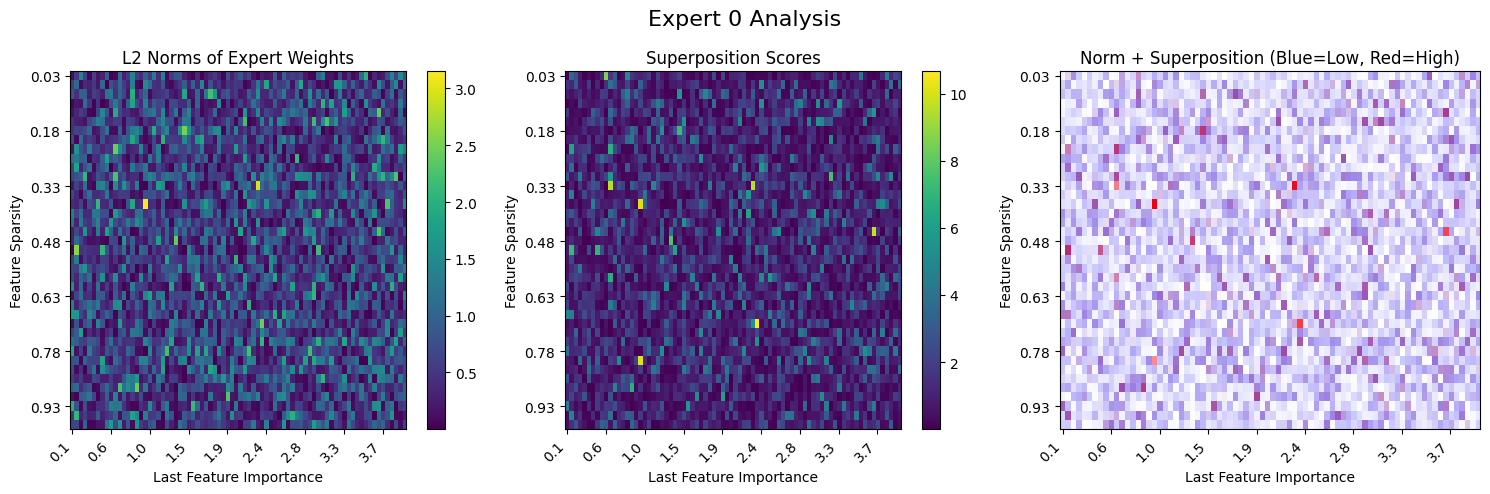

Creating plots for 1 experts
Creating plots for expert 0


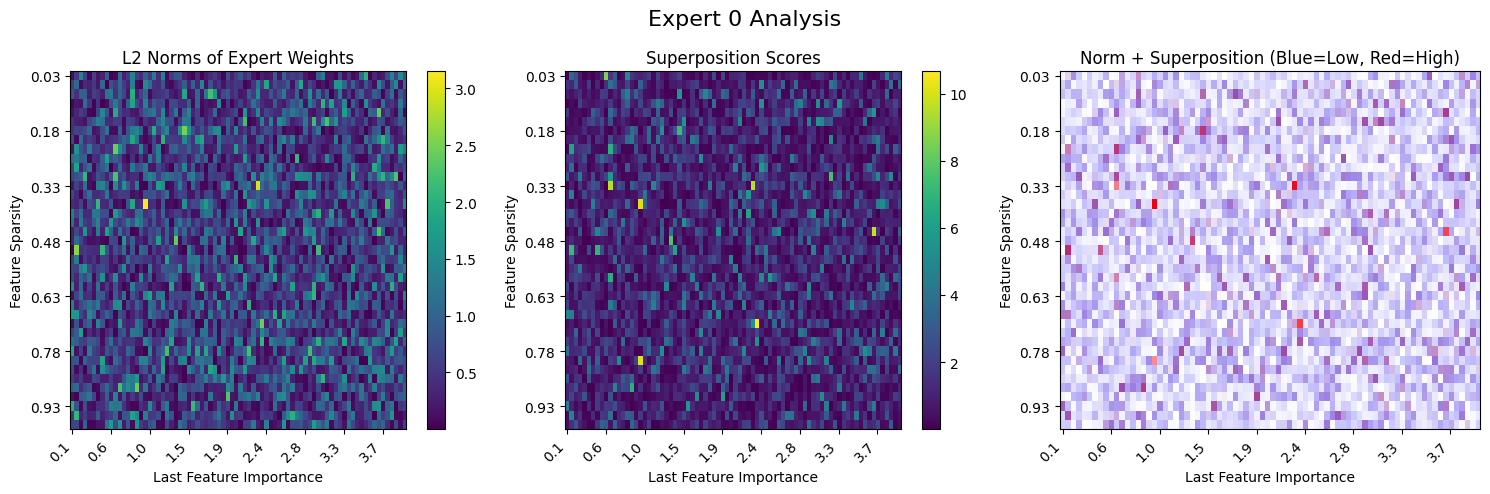

In [34]:
run_phase_change(2,1,1)

In [ ]:
run_phase_change(2,1,2)

In [ ]:
run_phase_change(3,1,1)

In [ ]:
run_phase_change(3,1,2)

In [ ]:
run_phase_change(3,1,3)

In [ ]:
run_phase_change(3,2,1)

In [ ]:
run_phase_change(3,2,2)

In [ ]:
run_phase_change(3,2,3)

Creating grid with 39 sparsity values and 78 importance values
Total grid points: 3042
Training 1 independent runs...
Training run 1/1...
Step 0: avg_loss=0.749721, lr=0.001000
Step 1: avg_loss=0.746040, lr=0.001000
Step 2: avg_loss=0.746151, lr=0.001000
Step 3: avg_loss=0.745775, lr=0.001000
Step 4: avg_loss=0.742679, lr=0.001000
Selecting best models per grid cell...
  Cell (0.03, 0.1): best loss 0.190276 (run 1)
  Cell (0.03, 0.2): best loss 0.829385 (run 1)
  Cell (0.03, 0.2): best loss 0.205486 (run 1)
  Cell (0.03, 0.3): best loss 0.139504 (run 1)
  Cell (0.03, 0.3): best loss 0.183685 (run 1)
Training completed in 1.95 seconds
Total models trained: 3042
Analyzing expert allocations for all grid points...
Analyzing 1 experts
Processing expert 0
Creating plots for expert 0


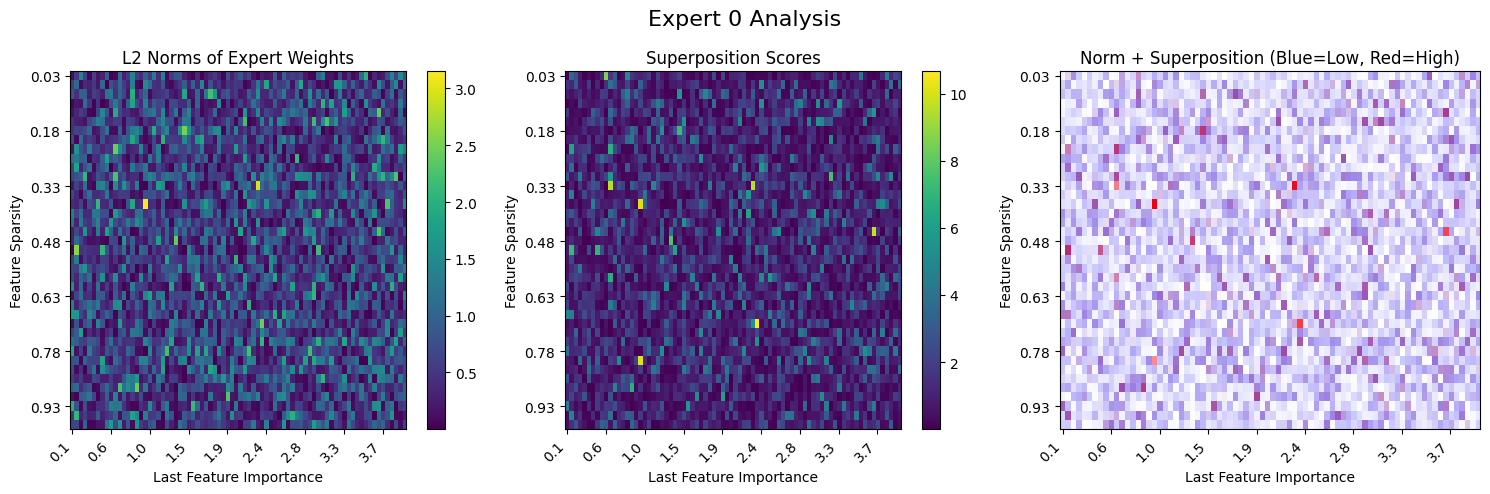

Creating plots for 1 experts
Creating plots for expert 0


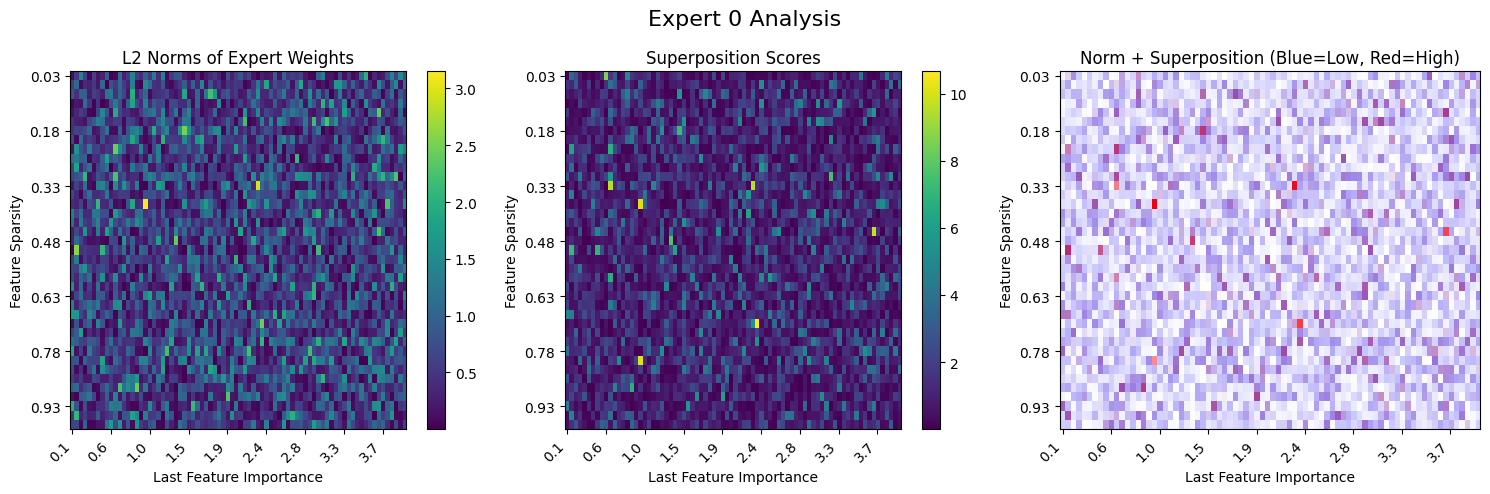

Grid results saved to: test_grid_results.npz
Grid size: 39 x 78 = 3042 points
Data includes: grid parameters, losses, expert weights, router weights, config metadata


'test_grid_results.npz'

In [32]:
config_211 = create_phase_change_grid_experiment_config(2, 1, 1)
training_results_211 = train_grid_models(config_211)
grid_results_211 = analyze_grid_models(training_results_211)
run_phase_change_analysis(config_211, grid_results_211)

save_grid_results(grid_results_211, config_211, "test_grid_results.npz")

Grid results loaded from: test_grid_results.npz
Grid size: 39 x 78 = 3042 points
Data includes: grid parameters, losses, expert weights, router weights
Analyzing 1 experts
Processing expert 0
Creating plots for expert 0


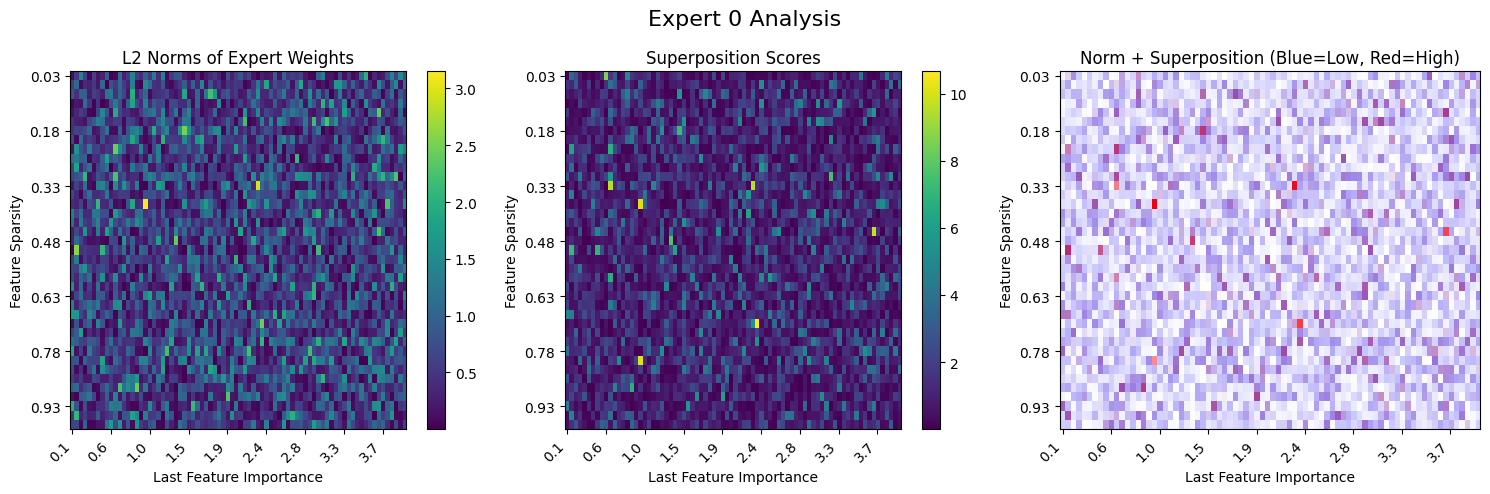

Creating plots for 1 experts
Creating plots for expert 0


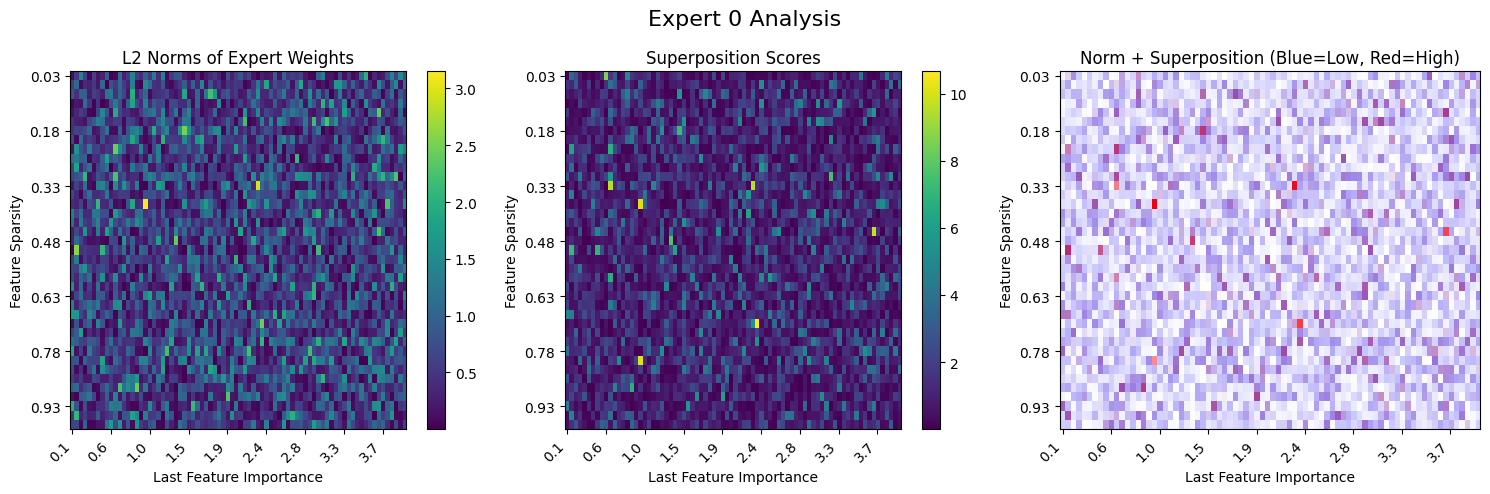

In [35]:
# Load the results
loaded_data = load_grid_results("test_grid_results.npz")
grid_results = loaded_data['grid_results']
sparsity_values = loaded_data['sparsity_values']
importance_values = loaded_data['importance_values']
config_params = loaded_data.get('config_params', {})

# Create a minimal config object with all required attributes
class SimpleConfig:
    def __init__(self, sparsity_values, importance_values, config_params):
        self.sparsity_values = sparsity_values
        self.importance_values = importance_values
        self.n_experts = config_params.get('n_experts', 1)
        self.n_features = config_params.get('n_features', 2)
        self.n_hidden = config_params.get('n_hidden', 1)
        self.n_active_experts = config_params.get('n_active_experts', 1)

simple_config = SimpleConfig(sparsity_values, importance_values, config_params)

# Run analysis directly
analysis_output = analyze_norm_and_superposition_all_experts(grid_results, simple_config)
plot_loss_grid_sparsity_last_feature_plotly(grid_results, simple_config, max_loss=.15)
plot_norm_and_superposition_analysis(analysis_output, simple_config)

In [ ]:
# # Save current experiment
# save_complete_experiment(grid_results_100, config_100, analysis_output_100, "experiment_100")

# # Load saved experiment
# loaded_data = load_grid_results("experiment_100_grid.npz")
# grid_results = loaded_data['grid_results']
# config_params = loaded_data['config_params']

# # Load analysis results
# analysis_output = load_analysis_results("experiment_100_analysis.npz")
# plot_norm_and_superposition_analysis(analysis_output, config_100)

# # Just save grid results
# save_grid_results(grid_results_100, config_100, "my_grid_results.npz")

# # Just save analysis results
# save_analysis_results(analysis_output_100, config_100, "my_analysis_results.npz")

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from phase_changes.sparsity_importance_grid_experiment import *
from helpers.expert_classification import *

# Set random seed
torch.manual_seed(np.random.randint(0, 10000))

# Create configuration for n=2, m=1, k=1, e=1
config_211 = GridExperimentConfig()

config_211.n_features = 2  # n=2
config_211.n_hidden = 1    # m=1  
config_211.n_experts = 1   # k=1
config_211.n_active_experts = 1  # e=1
config_211.steps = 5000     # Shorter training for faster experiments
config_211.n_models_per_cell = 7
config_211.sparsity_values = np.arange(0.025, 1.0, 0.025)
config_211.importance_values = np.concatenate([
    np.arange(0.1, 5.0, 0.1),
])

# Run the experiment
print("=== Training Grid Models ===")
training_results_211 = train_grid_models(config_211)


=== Training Grid Models ===
Creating grid with 19 sparsity values and 19 importance values
Total grid points: 361
Training 5 independent runs...
Training run 1/5...
Step 0: avg_loss=0.467838, lr=0.001000
Step 750: avg_loss=0.126859, lr=0.001000
Step 1500: avg_loss=0.083584, lr=0.001000
Step 2250: avg_loss=0.074465, lr=0.001000
Step 2999: avg_loss=0.072054, lr=0.001000
Training run 2/5...
Step 0: avg_loss=0.511513, lr=0.001000
Step 2999: avg_loss=0.071040, lr=0.001000
Training run 3/5...
Step 0: avg_loss=0.466554, lr=0.001000
Step 2999: avg_loss=0.071135, lr=0.001000
Training run 4/5...
Step 0: avg_loss=0.467605, lr=0.001000
Step 2999: avg_loss=0.069899, lr=0.001000
Training run 5/5...
Step 0: avg_loss=0.530256, lr=0.001000
Step 2999: avg_loss=0.068059, lr=0.001000
Selecting best models per grid cell...
  Cell (0.05, 0.1): best loss 0.014790 (run 1)
  Cell (0.05, 0.2): best loss 0.018718 (run 5)
  Cell (0.05, 0.3): best loss 0.022913 (run 3)
  Cell (0.05, 0.4): best loss 0.027521 (run 

Analyzing expert allocations for all grid points...

=== Analyzing Norm and Superposition ===
Analyzing expert 0


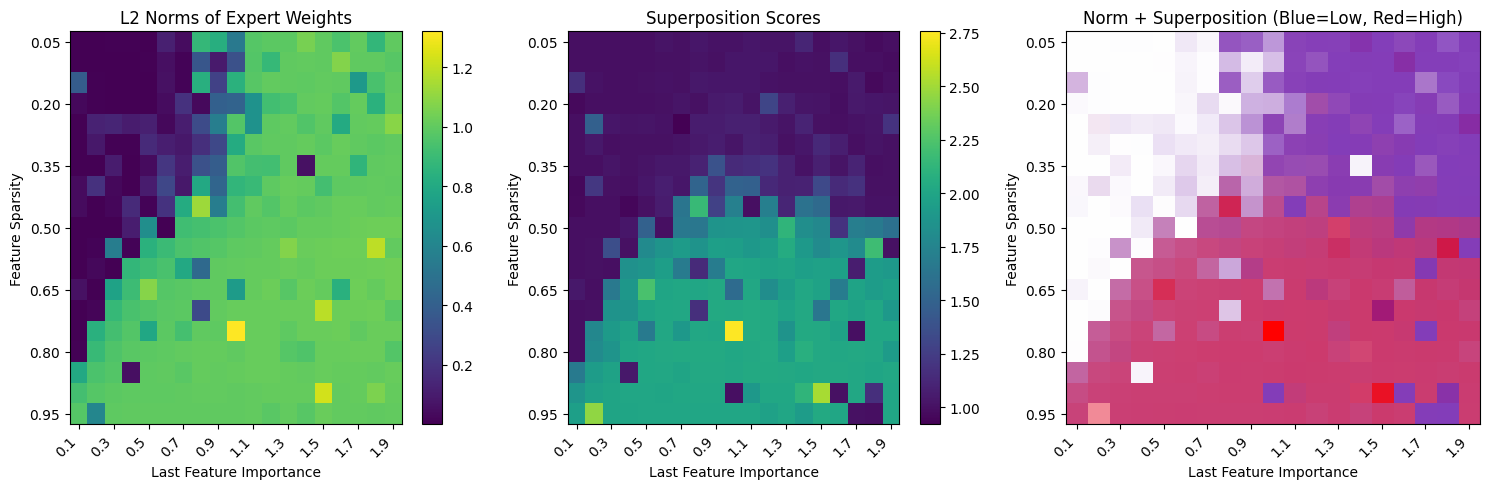


=== Summary Statistics ===
Grid size: 19 x 19 = 361 points
Mean norm: 0.737 ± 0.403
Mean superposition: 1.464 ± 0.468
Min norm: 0.000, Max norm: 1.321
Min superposition: 0.922, Max superposition: 2.756

=== Parameter Region Analysis ===
low_sparsity_low_importance:
  Mean norm: 0.162 ± 0.244
  Mean superposition: 1.060 ± 0.170
low_sparsity_high_importance:
  Mean norm: 0.939 ± 0.154
  Mean superposition: 1.086 ± 0.153
high_sparsity_low_importance:
  Mean norm: 0.745 ± 0.383
  Mean superposition: 1.730 ± 0.404
high_sparsity_high_importance:
  Mean norm: 1.015 ± 0.059
  Mean superposition: 1.893 ± 0.302


In [ ]:
grid_results_211 = analyze_grid_models(training_results_211)

analysis_output_211 = analyze_norm_and_superposition_all_experts(grid_results_211, config_211)

plot_loss_grid_sparsity_last_feature_plotly(grid_results_211, config_211, max_loss=.15)

plot_norm_and_superposition_analysis(analysis_output_211, grid_results_211)

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from phase_changes.sparsity_importance_grid_experiment import *
from helpers.expert_classification import *

# Set random seed
torch.manual_seed(np.random.randint(0, 10000))

# Create configuration for n=2, m=1, k=1, e=1
config_212 = GridExperimentConfig()

config_212.n_features = 2  # n=2
config_212.n_hidden = 1    # m=1  
config_212.n_experts = 2   # k=1
config_212.n_active_experts = 1  # e=1
config_212.steps = 5000     # Shorter training for faster experiments
config_212.n_models_per_cell = 7
config_212.sparsity_values = np.arange(0.025, 1.0, 0.025)
config_212.importance_values = np.concatenate([
    np.arange(0.1, 5.0, 0.1),
])

# Run the experiment
print("=== Training Grid Models ===")
training_results_212 = train_grid_models(config_212)


In [ ]:
grid_results_212 = analyze_grid_models(training_results_212)

analysis_output_212 = analyze_norm_and_superposition_all_experts(grid_results_212, config_212)

plot_loss_grid_sparsity_last_feature_plotly(grid_results_212, config_212, max_loss=.15)

plot_norm_and_superposition_analysis(analysis_output_212, grid_results_212)

out = analyze_and_plot_expert_allocation(grid_results_212, config_212)

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from phase_changes.sparsity_importance_grid_experiment import *
from helpers.expert_classification import *

# Set random seed
torch.manual_seed(np.random.randint(0, 10000))

# Create configuration for n=2, m=1, k=1, e=1
config_311_5 = GridExperimentConfig()
config_311_5.n_features = 3  # n=2
config_311_5.n_hidden = 1    # m=1  
config_311_5.n_experts = 1   # k=1
config_311_5.n_active_experts = 1  # e=1
config_311_5.steps = 5000     # Shorter training for faster experiments
config_311_5.n_models_per_cell = 7
config_311_5.sparsity_values = np.arange(0.025, 1.0, 0.025)
config_311_5.importance_values = np.concatenate([
    np.arange(0.1, 5.0, 0.1),
])

# Run the experiment
print("=== Training Grid Models ===")
training_results_311_5 = train_grid_models(config_311_5)


=== Training Grid Models ===
Creating grid with 19 sparsity values and 19 importance values
Total grid points: 361
Training 5 independent runs...
Training run 1/5...
Step 0: avg_loss=0.393407, lr=0.001000
Step 750: avg_loss=0.118867, lr=0.001000
Step 1500: avg_loss=0.086037, lr=0.001000
Step 2250: avg_loss=0.078783, lr=0.001000
Step 2999: avg_loss=0.077192, lr=0.001000
Training run 2/5...
Step 0: avg_loss=0.364065, lr=0.001000
Step 2999: avg_loss=0.079146, lr=0.001000
Training run 3/5...
Step 0: avg_loss=0.367382, lr=0.001000
Step 2999: avg_loss=0.080132, lr=0.001000
Training run 4/5...
Step 0: avg_loss=0.347352, lr=0.001000
Step 2999: avg_loss=0.080416, lr=0.001000
Training run 5/5...
Step 0: avg_loss=0.368609, lr=0.001000
Step 2999: avg_loss=0.078115, lr=0.001000
Selecting best models per grid cell...
  Cell (0.05, 0.1): best loss 0.041026 (run 4)
  Cell (0.05, 0.2): best loss 0.043666 (run 2)
  Cell (0.05, 0.3): best loss 0.049299 (run 3)
  Cell (0.05, 0.4): best loss 0.054597 (run 

In [ ]:
grid_results_311_5 = analyze_grid_models(training_results_311_5)

analysis_output_311_5 = analyze_norm_and_superposition_all_experts(grid_results_311_5, config_311_5)

plot_loss_grid_sparsity_last_feature_plotly(grid_results_311_5, config_311_5, max_loss=.15)

plot_norm_and_superposition_analysis(analysis_output_311_5, config_311_5)

Analyzing expert allocations for all grid points...

=== Analyzing Norm and Superposition ===
Analyzing expert 0


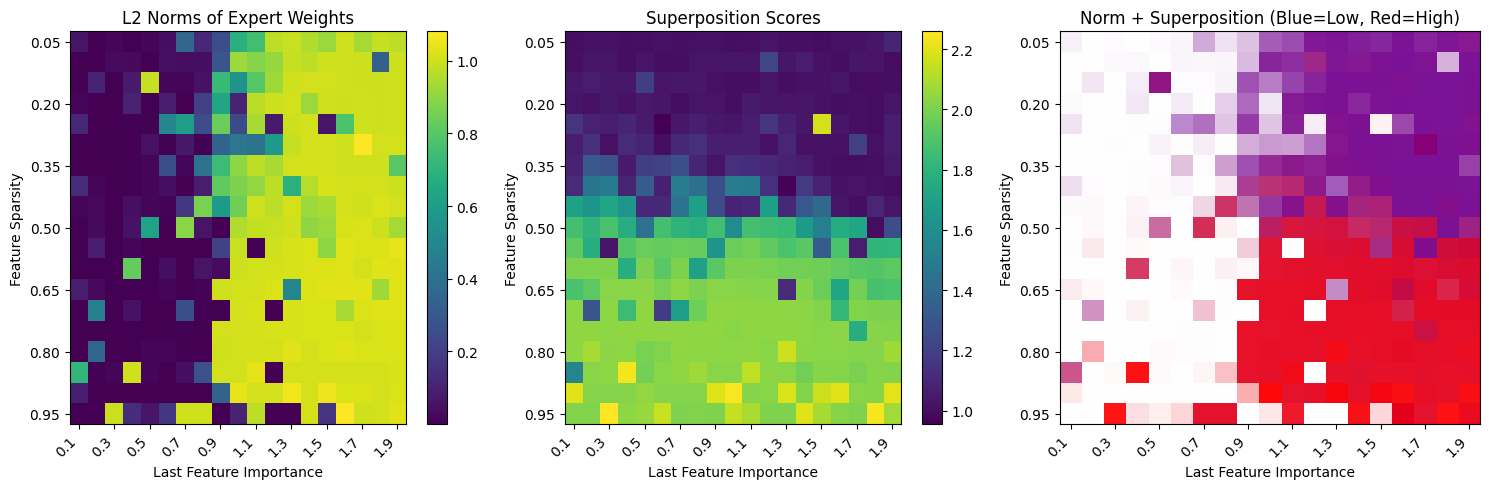


=== Summary Statistics ===
Grid size: 19 x 19 = 361 points
Mean norm: 0.555 ± 0.464
Mean superposition: 1.549 ± 0.465
Min norm: 0.000, Max norm: 1.080
Min superposition: 0.955, Max superposition: 2.259

=== Parameter Region Analysis ===
low_sparsity_low_importance:
  Mean norm: 0.142 ± 0.243
  Mean superposition: 1.133 ± 0.186
low_sparsity_high_importance:
  Mean norm: 0.899 ± 0.216
  Mean superposition: 1.077 ± 0.164
high_sparsity_low_importance:
  Mean norm: 0.158 ± 0.314
  Mean superposition: 1.950 ± 0.195
high_sparsity_high_importance:
  Mean norm: 0.937 ± 0.254
  Mean superposition: 1.948 ± 0.220


In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from phase_changes.sparsity_importance_grid_experiment import *
from helpers.expert_classification import *

# Set random seed
torch.manual_seed(np.random.randint(0, 10000))

# Create configuration for n=2, m=1, k=1, e=1
config_312_5 = GridExperimentConfig()
config_312_5.n_features = 3  # n=2
config_312_5.n_hidden = 1    # m=1  
config_312_5.n_experts = 2   # k=1
config_312_5.n_active_experts = 1  # e=1
config_312_5.steps = 5000     # Shorter training for faster experiments
config_312_5.n_models_per_cell = 7
config_312_5.sparsity_values = np.arange(0.025, 1.0, 0.025)
config_312_5.importance_values = np.concatenate([
    np.arange(0.1, 5.0, 0.1),
])

# Run the experiment
print("=== Training Grid Models ===")
training_results_312_5 = train_grid_models(config_312_5)


=== Training Grid Models ===
Creating grid with 19 sparsity values and 19 importance values
Total grid points: 361
Training 5 independent runs...
Training run 1/5...
Step 0: avg_loss=0.306900, lr=0.001000
Step 750: avg_loss=0.096284, lr=0.001000
Step 1500: avg_loss=0.076858, lr=0.001000
Step 2250: avg_loss=0.072463, lr=0.001000
Step 2999: avg_loss=0.071411, lr=0.001000
Training run 2/5...
Step 0: avg_loss=0.268305, lr=0.001000
Step 2999: avg_loss=0.067463, lr=0.001000
Training run 3/5...
Step 0: avg_loss=0.325103, lr=0.001000
Step 2999: avg_loss=0.067575, lr=0.001000
Training run 4/5...
Step 0: avg_loss=0.279279, lr=0.001000
Step 2999: avg_loss=0.070176, lr=0.001000
Training run 5/5...
Step 0: avg_loss=0.279462, lr=0.001000
Step 2999: avg_loss=0.069102, lr=0.001000
Selecting best models per grid cell...
  Cell (0.05, 0.1): best loss 0.045531 (run 2)
  Cell (0.05, 0.2): best loss 0.026021 (run 1)
  Cell (0.05, 0.3): best loss 0.029747 (run 1)
  Cell (0.05, 0.4): best loss 0.031251 (run 

In [ ]:
grid_results_312_5 = analyze_grid_models(training_results_312_5)

analysis_output_312_5 = analyze_norm_and_superposition_all_experts(grid_results_312_5, config_312_5)

plot_loss_grid_sparsity_last_feature_plotly(grid_results_312_5, config_312_5, max_loss=.15)

plot_norm_and_superposition_analysis(analysis_output_312_5, config_312_5)

out = analyze_and_plot_expert_allocation(grid_results_312_5, config_312_5)

Analyzing expert allocations for all grid points...

=== Analyzing Norm and Superposition ===
Analyzing expert 0


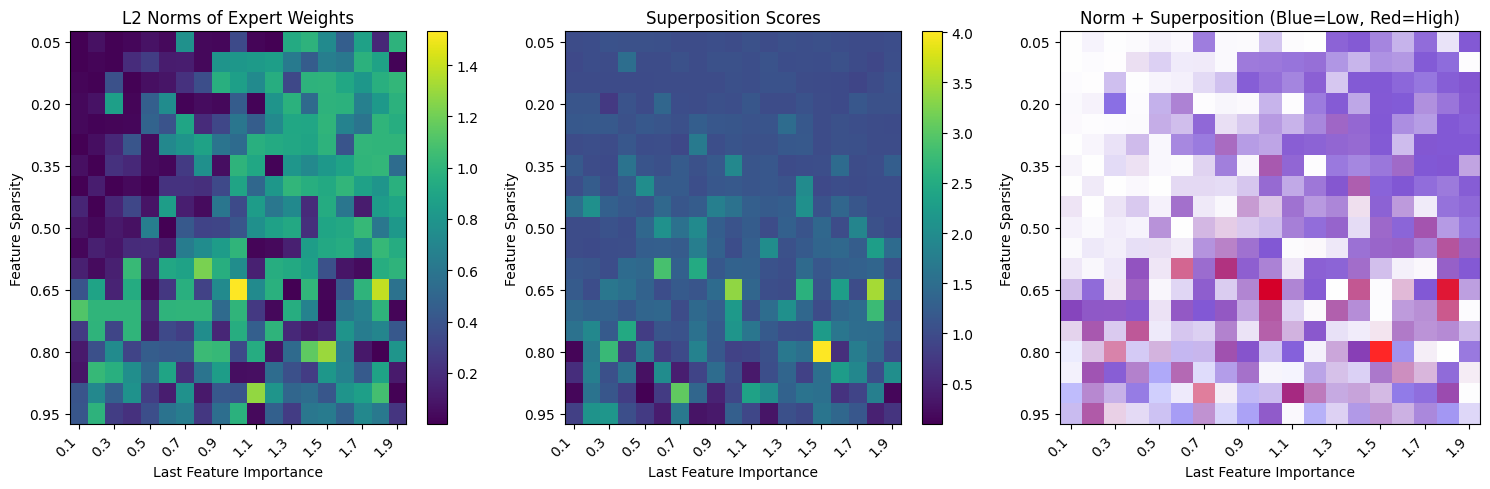

Analyzing expert 1


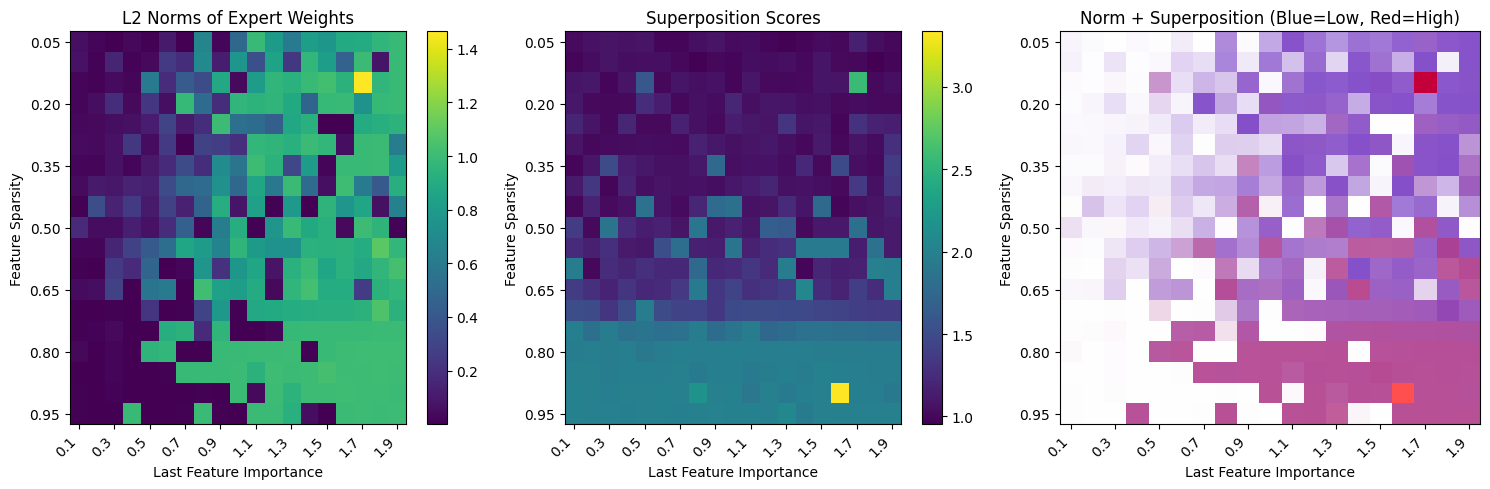


=== Summary Statistics ===
Grid size: 19 x 19 = 361 points
Mean norm: 0.521 ± 0.422
Mean superposition: 1.413 ± 0.412
Min norm: 0.000, Max norm: 1.465
Min superposition: 0.953, Max superposition: 3.336

=== Parameter Region Analysis ===
low_sparsity_low_importance:
  Mean norm: 0.214 ± 0.247
  Mean superposition: 1.107 ± 0.169
low_sparsity_high_importance:
  Mean norm: 0.727 ± 0.331
  Mean superposition: 1.115 ± 0.211
high_sparsity_low_importance:
  Mean norm: 0.259 ± 0.361
  Mean superposition: 1.664 ± 0.354
high_sparsity_high_importance:
  Mean norm: 0.819 ± 0.335
  Mean superposition: 1.703 ± 0.375



=== Analyzing Norm and Superposition ===


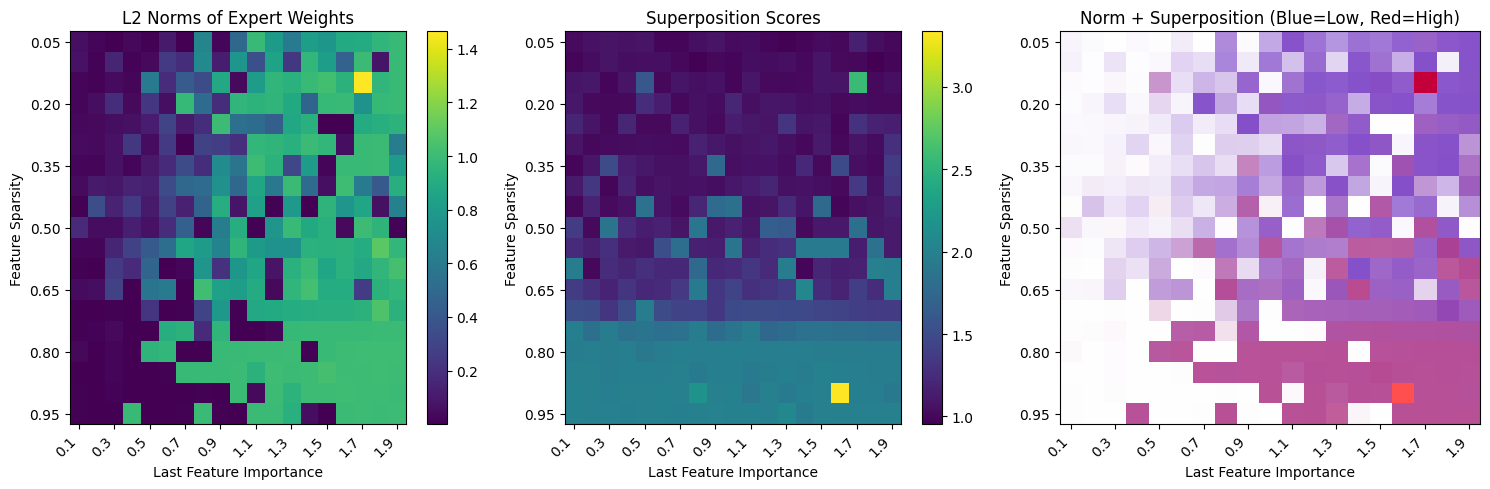


=== Summary Statistics ===
Grid size: 19 x 19 = 361 points
Mean norm: 0.521 ± 0.422
Mean superposition: 1.413 ± 0.412
Min norm: 0.000, Max norm: 1.465
Min superposition: 0.953, Max superposition: 3.336

=== Parameter Region Analysis ===
low_sparsity_low_importance:
  Mean norm: 0.214 ± 0.247
  Mean superposition: 1.107 ± 0.169
low_sparsity_high_importance:
  Mean norm: 0.727 ± 0.331
  Mean superposition: 1.115 ± 0.211
high_sparsity_low_importance:
  Mean norm: 0.259 ± 0.361
  Mean superposition: 1.664 ± 0.354
high_sparsity_high_importance:
  Mean norm: 0.819 ± 0.335
  Mean superposition: 1.703 ± 0.375


In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from phase_changes.sparsity_importance_grid_experiment import *
from helpers.expert_classification import *

# Set random seed
torch.manual_seed(np.random.randint(0, 10000))

# Create configuration for n=2, m=1, k=1, e=1
config_313_5 = GridExperimentConfig()
config_313_5.n_features = 3  # n=2
config_313_5.n_hidden = 1    # m=1  
config_313_5.n_experts = 3   # k=1
config_313_5.n_active_experts = 1  # e=1
config_313_5.steps = 5000     # Shorter training for faster experiments
config_313_5.n_models_per_cell = 7
config_313_5.sparsity_values = np.arange(0.025, 1.0, 0.025)
config_313_5.importance_values = np.concatenate([
    np.arange(0.1, 5.0, 0.1),
])

# Run the experiment
print("=== Training Grid Models ===")
training_results_313_5 = train_grid_models(config_313_5)


=== Training Grid Models ===
Creating grid with 19 sparsity values and 19 importance values
Total grid points: 361
Training 5 independent runs...
Training run 1/5...
Step 0: avg_loss=0.250653, lr=0.001000
Step 750: avg_loss=0.085144, lr=0.001000
Step 1500: avg_loss=0.070698, lr=0.001000
Step 2250: avg_loss=0.067513, lr=0.001000
Step 2999: avg_loss=0.066748, lr=0.001000
Training run 2/5...
Step 0: avg_loss=0.246232, lr=0.001000
Step 2999: avg_loss=0.065110, lr=0.001000
Training run 3/5...
Step 0: avg_loss=0.252078, lr=0.001000
Step 2999: avg_loss=0.065096, lr=0.001000
Training run 4/5...
Step 0: avg_loss=0.265588, lr=0.001000
Step 2999: avg_loss=0.064786, lr=0.001000
Training run 5/5...
Step 0: avg_loss=0.255033, lr=0.001000
Step 2999: avg_loss=0.064725, lr=0.001000
Selecting best models per grid cell...
  Cell (0.05, 0.1): best loss 0.039786 (run 1)
  Cell (0.05, 0.2): best loss 0.036548 (run 1)
  Cell (0.05, 0.3): best loss 0.027263 (run 4)
  Cell (0.05, 0.4): best loss 0.030717 (run 

In [ ]:
grid_results_313_5 = analyze_grid_models(training_results_313_5)

analysis_output_313_5 = analyze_norm_and_superposition_all_experts(grid_results_313_5, config_313_5)

plot_loss_grid_sparsity_last_feature_plotly(grid_results_313_5, config_313_5, max_loss=.15)

plot_norm_and_superposition_analysis(analysis_output_313_5, config_313_5)

out = analyze_and_plot_expert_allocation(grid_results_313_5, config_313_5)

Analyzing expert allocations for all grid points...

=== Analyzing Norm and Superposition ===
Analyzing expert 0


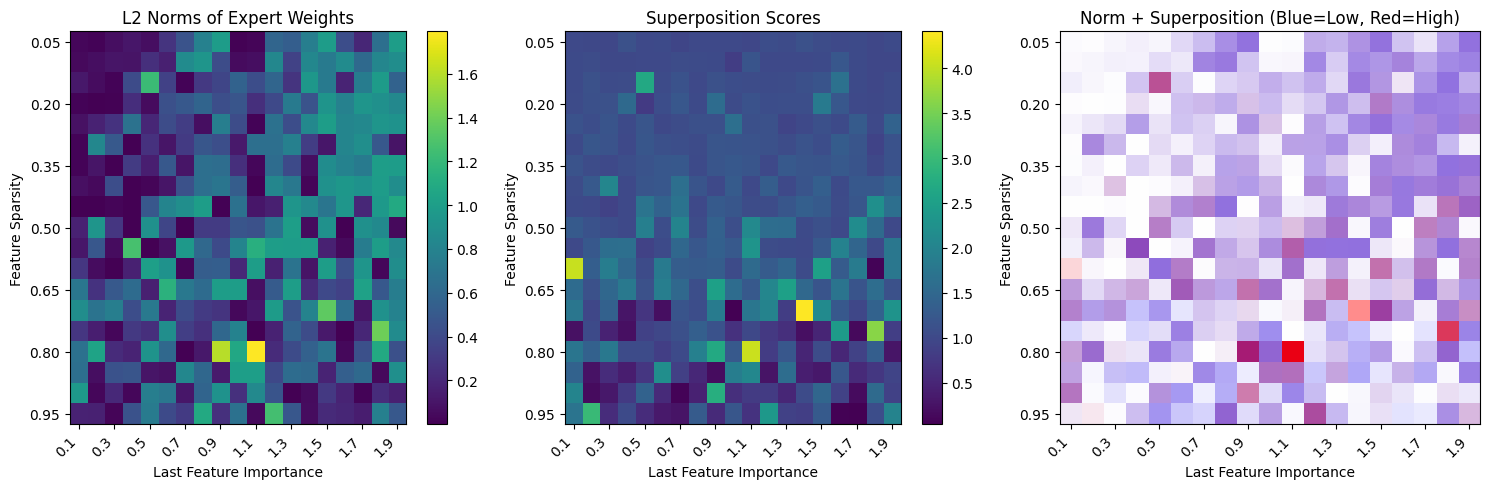

Analyzing expert 1


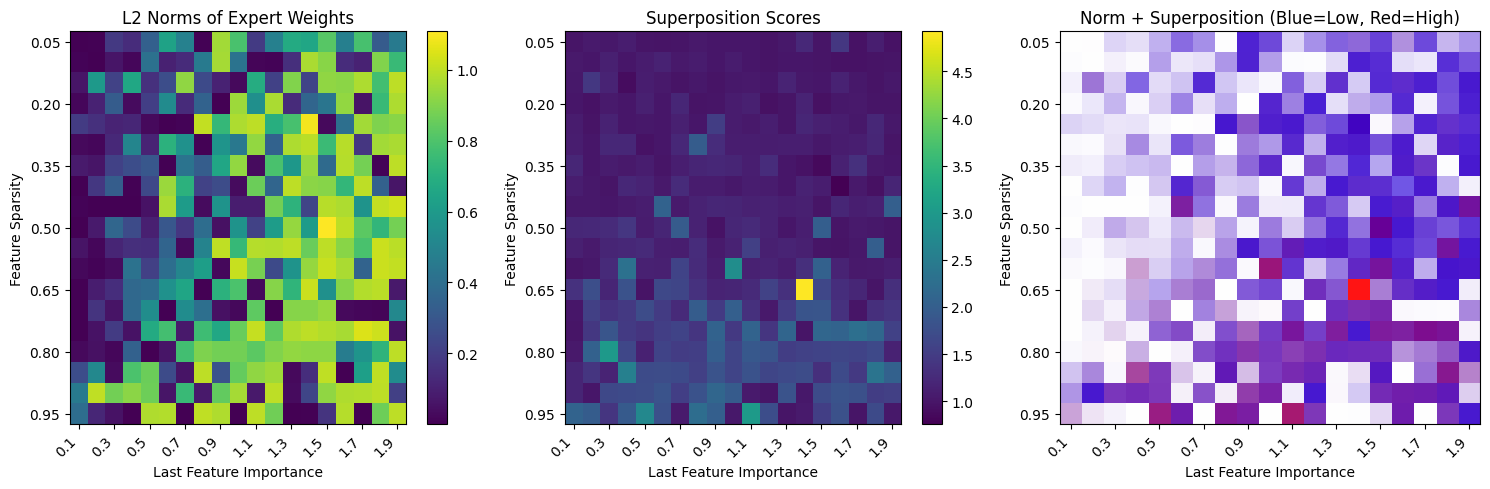

Analyzing expert 2


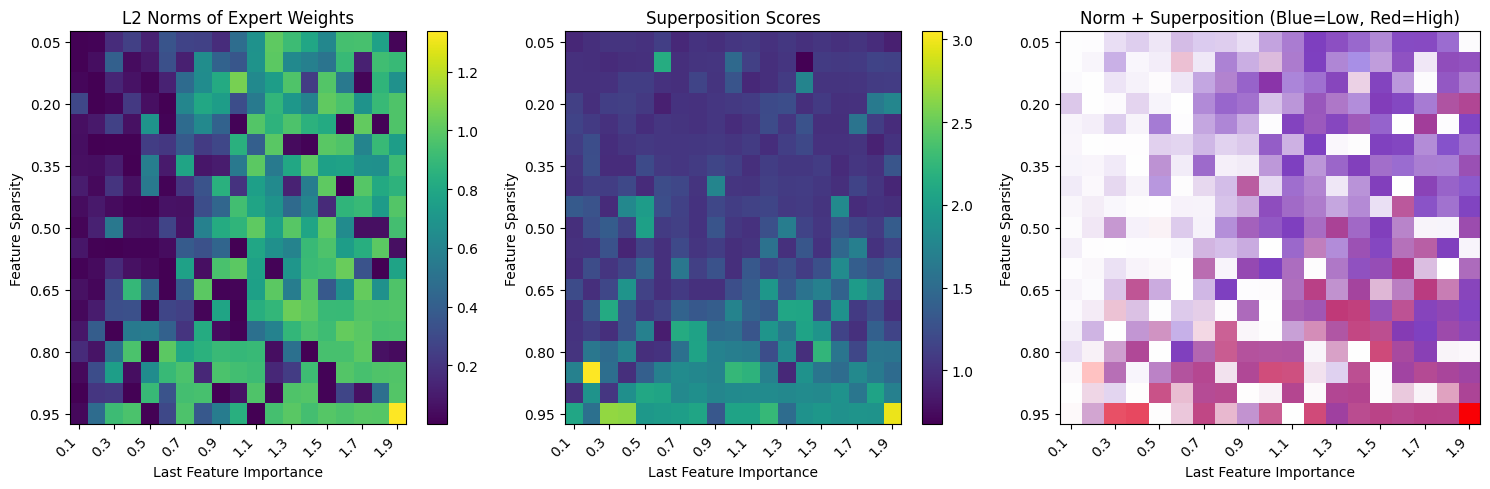


=== Summary Statistics ===
Grid size: 19 x 19 = 361 points
Mean norm: 0.505 ± 0.382
Mean superposition: 1.309 ± 0.385
Min norm: 0.000, Max norm: 1.337
Min superposition: 0.675, Max superposition: 3.048

=== Parameter Region Analysis ===
low_sparsity_low_importance:
  Mean norm: 0.225 ± 0.237
  Mean superposition: 1.107 ± 0.206
low_sparsity_high_importance:
  Mean norm: 0.687 ± 0.304
  Mean superposition: 1.098 ± 0.178
high_sparsity_low_importance:
  Mean norm: 0.360 ± 0.349
  Mean superposition: 1.443 ± 0.449
high_sparsity_high_importance:
  Mean norm: 0.697 ± 0.373
  Mean superposition: 1.541 ± 0.385



=== Analyzing Norm and Superposition ===


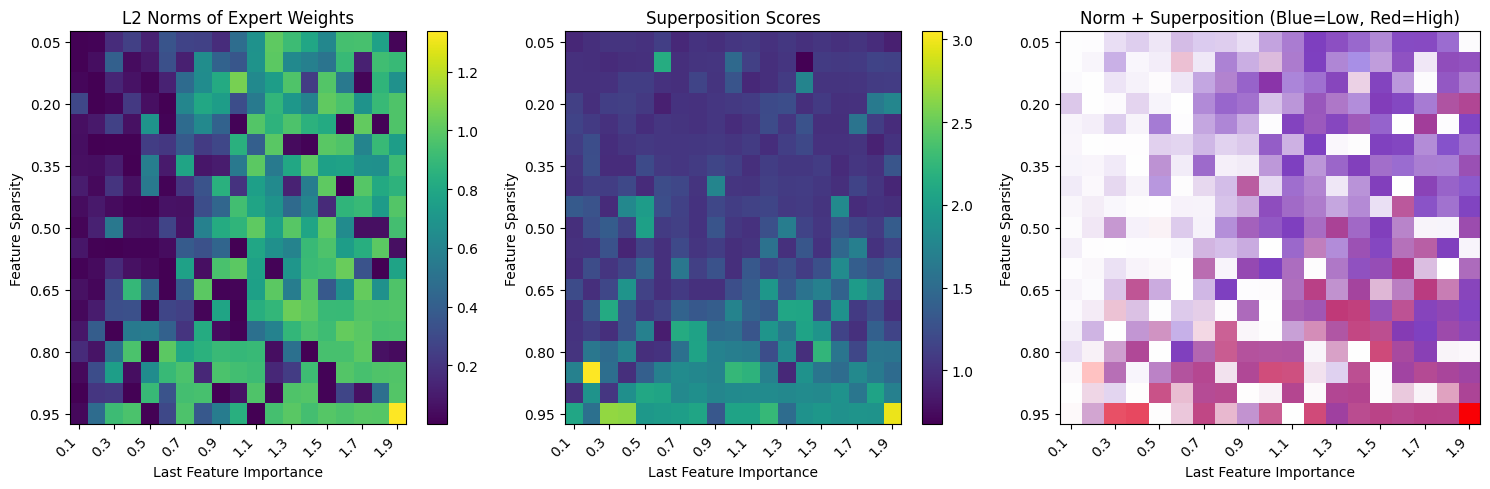


=== Summary Statistics ===
Grid size: 19 x 19 = 361 points
Mean norm: 0.505 ± 0.382
Mean superposition: 1.309 ± 0.385
Min norm: 0.000, Max norm: 1.337
Min superposition: 0.675, Max superposition: 3.048

=== Parameter Region Analysis ===
low_sparsity_low_importance:
  Mean norm: 0.225 ± 0.237
  Mean superposition: 1.107 ± 0.206
low_sparsity_high_importance:
  Mean norm: 0.687 ± 0.304
  Mean superposition: 1.098 ± 0.178
high_sparsity_low_importance:
  Mean norm: 0.360 ± 0.349
  Mean superposition: 1.443 ± 0.449
high_sparsity_high_importance:
  Mean norm: 0.697 ± 0.373
  Mean superposition: 1.541 ± 0.385


In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from phase_changes.sparsity_importance_grid_experiment import *
from helpers.expert_classification import *

# Set random seed
torch.manual_seed(np.random.randint(0, 10000))

# Create configuration for n=2, m=1, k=1, e=1
config_321_5 = GridExperimentConfig()
config_321_5.n_features = 3  # n=2
config_321_5.n_hidden = 2    # m=1  
config_321_5.n_experts = 1   # k=1
config_321_5.n_active_experts = 1  # e=1
config_321_5.steps = 5000     # Shorter training for faster experiments
config_321_5.n_models_per_cell = 7
config_321_5.sparsity_values = np.arange(0.025, 1.0, 0.025)
config_321_5.importance_values = np.concatenate([
    np.arange(0.1, 5.0, 0.1),
])

# Run the experiment
print("=== Training Grid Models ===")
training_results_321_5 = train_grid_models(config_321_5)


=== Training Grid Models ===
Creating grid with 19 sparsity values and 19 importance values
Total grid points: 361
Training 5 independent runs...
Training run 1/5...
Step 0: avg_loss=0.304903, lr=0.001000
Step 750: avg_loss=0.079032, lr=0.001000
Step 1500: avg_loss=0.056566, lr=0.001000
Step 2250: avg_loss=0.052110, lr=0.001000
Step 2999: avg_loss=0.050480, lr=0.001000
Training run 2/5...
Step 0: avg_loss=0.306770, lr=0.001000
Step 2999: avg_loss=0.052696, lr=0.001000
Training run 3/5...
Step 0: avg_loss=0.327657, lr=0.001000
Step 2999: avg_loss=0.049577, lr=0.001000
Training run 4/5...
Step 0: avg_loss=0.298067, lr=0.001000
Step 2999: avg_loss=0.053438, lr=0.001000
Training run 5/5...
Step 0: avg_loss=0.329041, lr=0.001000
Step 2999: avg_loss=0.050692, lr=0.001000
Selecting best models per grid cell...
  Cell (0.05, 0.1): best loss 0.012793 (run 4)
  Cell (0.05, 0.2): best loss 0.015739 (run 5)
  Cell (0.05, 0.3): best loss 0.018681 (run 5)
  Cell (0.05, 0.4): best loss 0.023000 (run 

In [ ]:
grid_results_321_5 = analyze_grid_models(training_results_321_5)

analysis_output_321_5 = analyze_norm_and_superposition_all_experts(grid_results_321_5, config_321_5)

plot_loss_grid_sparsity_last_feature_plotly(grid_results_321_5, config_321_5, max_loss=.15)

plot_norm_and_superposition_analysis(analysis_output_321_5, config_321_5)

Analyzing expert allocations for all grid points...

=== Analyzing Norm and Superposition ===
Analyzing expert 0


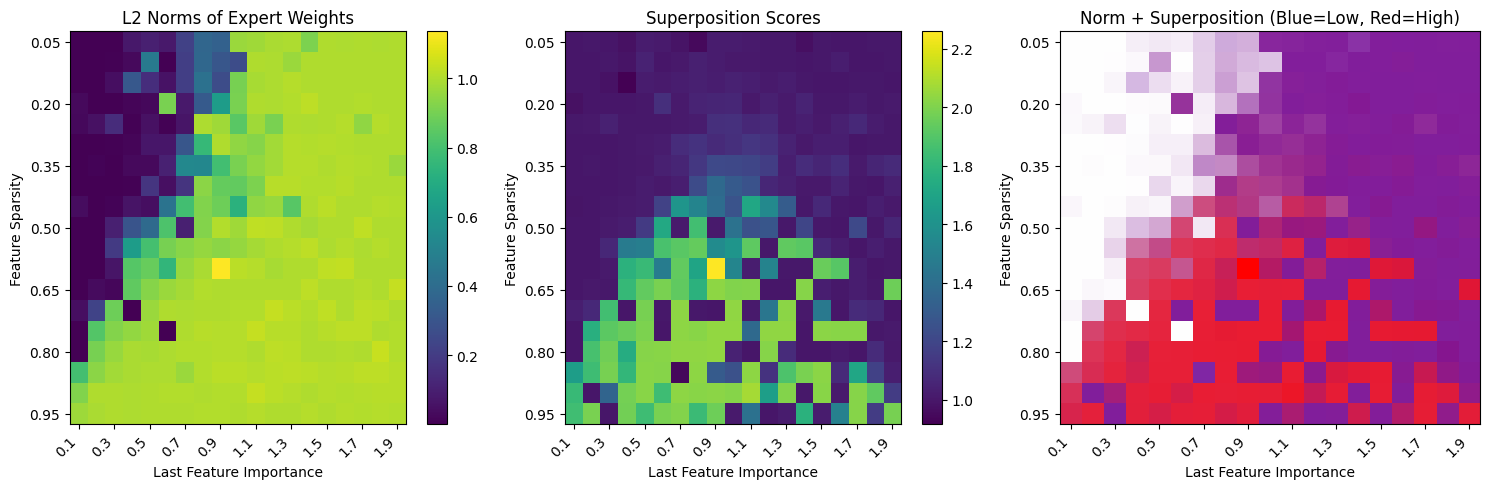


=== Summary Statistics ===
Grid size: 19 x 19 = 361 points
Mean norm: 0.760 ± 0.392
Mean superposition: 1.285 ± 0.400
Min norm: 0.000, Max norm: 1.136
Min superposition: 0.917, Max superposition: 2.259

=== Parameter Region Analysis ===
low_sparsity_low_importance:
  Mean norm: 0.223 ± 0.305
  Mean superposition: 1.045 ± 0.112
low_sparsity_high_importance:
  Mean norm: 0.974 ± 0.088
  Mean superposition: 1.055 ± 0.110
high_sparsity_low_importance:
  Mean norm: 0.752 ± 0.385
  Mean superposition: 1.613 ± 0.431
high_sparsity_high_importance:
  Mean norm: 1.009 ± 0.013
  Mean superposition: 1.390 ± 0.432


In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from phase_changes.sparsity_importance_grid_experiment import *
from helpers.expert_classification import *

# Set random seed
torch.manual_seed(np.random.randint(0, 10000))

# Create configuration for n=2, m=1, k=1, e=1
config_322_5 = GridExperimentConfig()
config_322_5.n_features = 3  # n=2
config_322_5.n_hidden = 2    # m=1  
config_322_5.n_experts = 2   # k=1
config_322_5.n_active_experts = 1  # e=1
config_322_5.steps = 5000     # Shorter training for faster experiments
config_322_5.n_models_per_cell = 7
config_322_5.sparsity_values = np.arange(0.025, 1.0, 0.025)
config_322_5.importance_values = np.concatenate([
    np.arange(0.1, 5.0, 0.1),
])

# Run the experiment
print("=== Training Grid Models ===")
training_results_322_5 = train_grid_models(config_322_5)


=== Training Grid Models ===
Creating grid with 19 sparsity values and 19 importance values
Total grid points: 361
Training 5 independent runs...
Training run 1/5...
Step 0: avg_loss=0.260488, lr=0.001000
Step 750: avg_loss=0.066287, lr=0.001000
Step 1500: avg_loss=0.049629, lr=0.001000
Step 2250: avg_loss=0.046286, lr=0.001000
Step 2999: avg_loss=0.045200, lr=0.001000
Training run 2/5...
Step 0: avg_loss=0.246013, lr=0.001000
Step 2999: avg_loss=0.047010, lr=0.001000
Training run 3/5...
Step 0: avg_loss=0.272205, lr=0.001000
Step 2999: avg_loss=0.047902, lr=0.001000
Training run 4/5...
Step 0: avg_loss=0.264538, lr=0.001000
Step 2999: avg_loss=0.048412, lr=0.001000
Training run 5/5...
Step 0: avg_loss=0.286424, lr=0.001000
Step 2999: avg_loss=0.045679, lr=0.001000
Selecting best models per grid cell...
  Cell (0.05, 0.1): best loss 0.036558 (run 2)
  Cell (0.05, 0.2): best loss 0.014135 (run 1)
  Cell (0.05, 0.3): best loss 0.013876 (run 4)
  Cell (0.05, 0.4): best loss 0.016421 (run 

In [ ]:
grid_results_322_5 = analyze_grid_models(training_results_322_5)

analysis_output_322_5 = analyze_norm_and_superposition_all_experts(grid_results_322_5, config_322_5)

plot_loss_grid_sparsity_last_feature_plotly(grid_results_322_5, config_322_5, max_loss=.15)

plot_norm_and_superposition_analysis(analysis_output_322_5, config_322_5)

out = analyze_and_plot_expert_allocation(grid_results_322_5, config_322_5)

Analyzing expert allocations for all grid points...

=== Analyzing Norm and Superposition ===
Analyzing expert 0


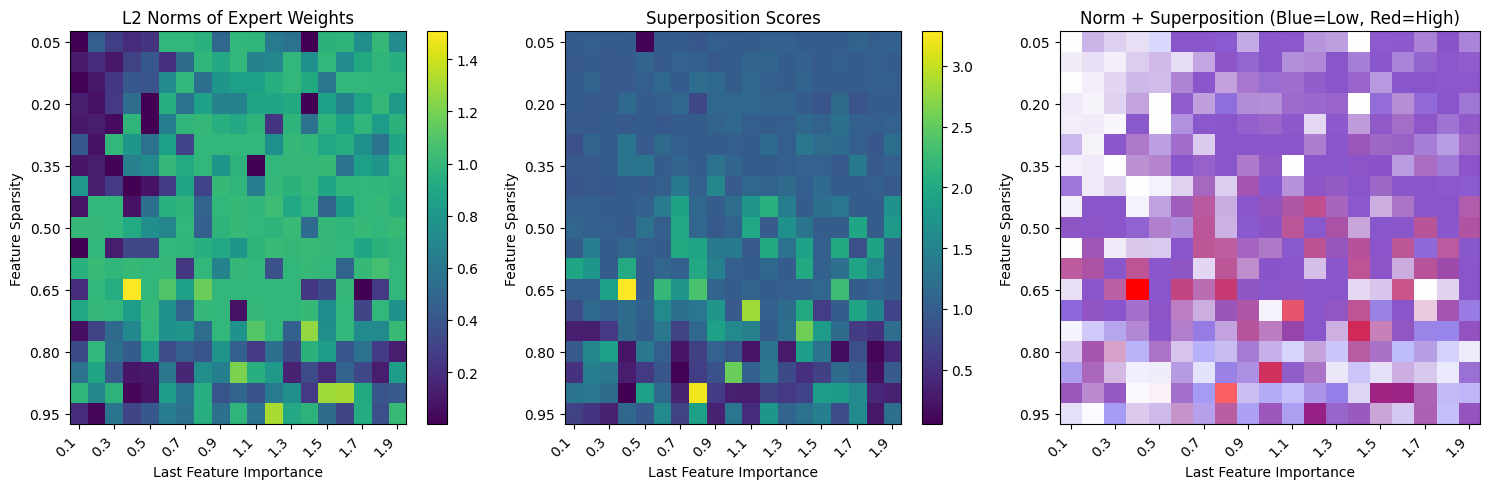

Analyzing expert 1


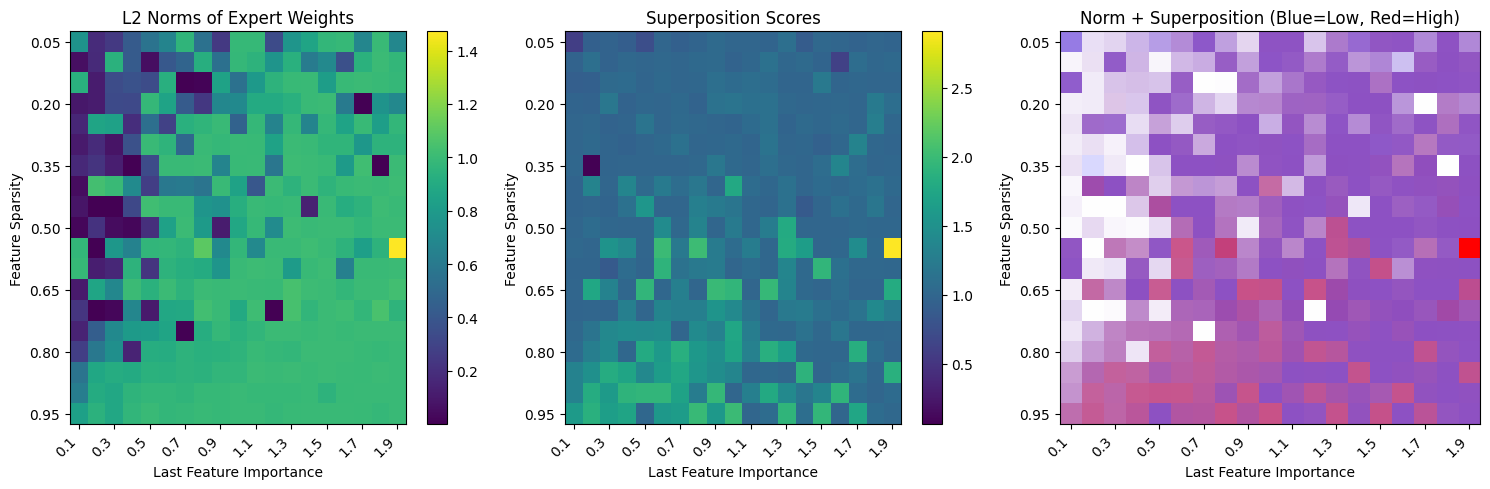


=== Summary Statistics ===
Grid size: 19 x 19 = 361 points
Mean norm: 0.784 ± 0.316
Mean superposition: 1.187 ± 0.308
Min norm: 0.000, Max norm: 1.472
Min superposition: 0.061, Max superposition: 2.908

=== Parameter Region Analysis ===
low_sparsity_low_importance:
  Mean norm: 0.528 ± 0.352
  Mean superposition: 1.020 ± 0.161
low_sparsity_high_importance:
  Mean norm: 0.859 ± 0.221
  Mean superposition: 1.050 ± 0.121
high_sparsity_low_importance:
  Mean norm: 0.729 ± 0.339
  Mean superposition: 1.386 ± 0.331
high_sparsity_high_importance:
  Mean norm: 0.975 ± 0.126
  Mean superposition: 1.267 ± 0.360


Analyzing expert allocations for all grid points...

=== Analyzing Norm and Superposition ===


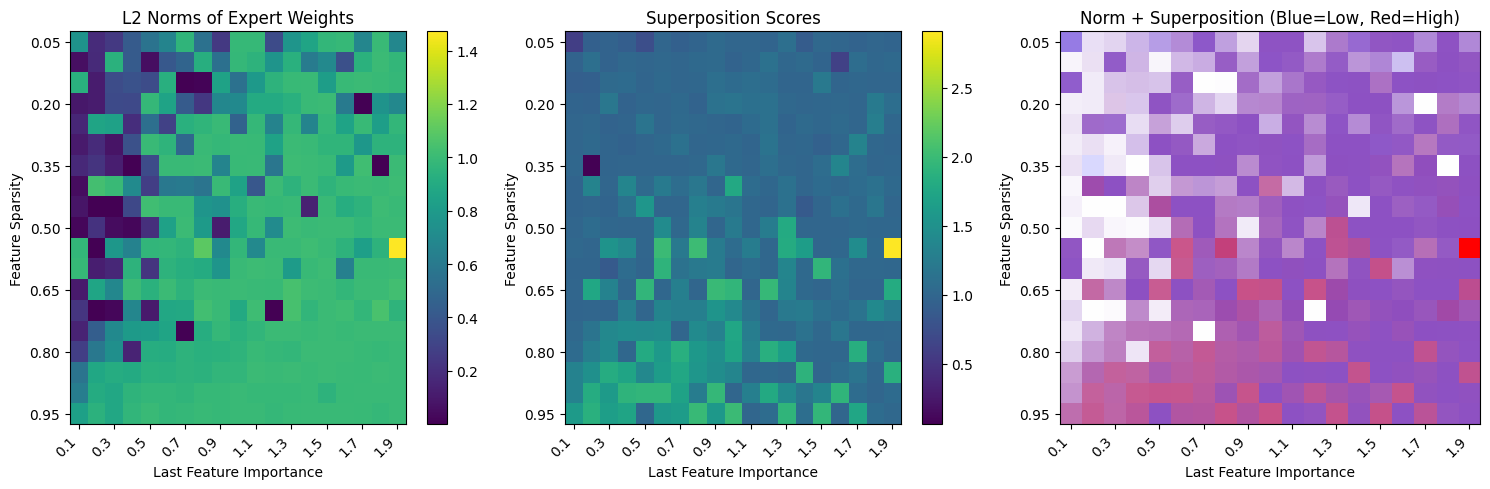


=== Summary Statistics ===
Grid size: 19 x 19 = 361 points
Mean norm: 0.784 ± 0.316
Mean superposition: 1.187 ± 0.308
Min norm: 0.000, Max norm: 1.472
Min superposition: 0.061, Max superposition: 2.908

=== Parameter Region Analysis ===
low_sparsity_low_importance:
  Mean norm: 0.528 ± 0.352
  Mean superposition: 1.020 ± 0.161
low_sparsity_high_importance:
  Mean norm: 0.859 ± 0.221
  Mean superposition: 1.050 ± 0.121
high_sparsity_low_importance:
  Mean norm: 0.729 ± 0.339
  Mean superposition: 1.386 ± 0.331
high_sparsity_high_importance:
  Mean norm: 0.975 ± 0.126
  Mean superposition: 1.267 ± 0.360


In [ ]:
config_323 = create_phase_change_grid_experiment_config(3, 2, 3)
training_results_323 = train_grid_models(config_323)
run_phase_change_analysis(config_323, training_results_323)

# Simplest Model